# Numerai Feature EDA

* Tournament data and example predictions change every week
* Training and validation data only change periodically

---
## Load libraries

In [73]:
# libs
import json
import scipy
import matplotlib
import numpy as np
import pandas as pd
import random
import sklearn
import lightgbm
import matplotlib.pyplot as plt
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm, ensemble
)
from numerapi import NumerAPI
from utils.utils import (
    save_model, load_model, neutralize, get_biggest_change_features, 
    validation_metrics
)

In [2]:
# see current round
napi = NumerAPI()
current_round = napi.get_current_round()
print(f"Current round #: {current_round}")

Current round #: 312


---
## Review features

In [3]:
# load features.json file
with open("data/features.json", "r") as f:
    feature_metadata = json.load(f)

In [4]:
# view feature keys
feature_metadata["feature_sets"].keys()

dict_keys(['small', 'medium', 'v2_equivalent_features', 'v3_equivalent_features', 'fncv3_features'])

In [5]:
# review small, medium, and other
features_small = feature_metadata["feature_sets"]["small"]
features_medium = feature_metadata["feature_sets"]["medium"]
features_eqv2 = feature_metadata["feature_sets"]["v2_equivalent_features"]
features_eqv3 = feature_metadata["feature_sets"]["v3_equivalent_features"]
features_fncv3 = feature_metadata["feature_sets"]["fncv3_features"]

In [6]:
# length of features
print("Length of small features         :", len(features_small))
print("Length of medium features        :", len(features_medium))
print("Length of v2 equivalent features :", len(features_eqv2))
print("Length of v3 equivalent features :", len(features_eqv3))
print("Length of fncv3 features         :", len(features_fncv3))

Length of small features         : 38
Length of medium features        : 472
Length of v2 equivalent features : 304
Length of v3 equivalent features : 1050
Length of fncv3 features         : 420


---
## Load training data

In [7]:
# read training data
df = pd.read_parquet('data/train.parquet')
df.head()

,era,data_type,feature_honoured_observational_balaamite,feature_polaroid_vadose_quinze,feature_untidy_withdrawn_bargeman,feature_genuine_kyphotic_trehala,feature_unenthralled_sportful_schoolhouse,feature_divulsive_explanatory_ideologue,feature_ichthyotic_roofed_yeshiva,feature_waggly_outlandish_carbonisation,...,target_paul_v4_20,target_paul_v4_60,target_george_v4_20,target_george_v4_60,target_william_v4_20,target_william_v4_60,target_arthur_v4_20,target_arthur_v4_60,target_thomas_v4_20,target_thomas_v4_60
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,train,1.0,0.50,1.00,1.00,0.00,0.00,1.00,1.00,...,0.50,0.25,0.25,0.00,0.333333,0.000000,0.500000,0.500000,0.166667,0.000000
n003bee128c2fcfc,0001,train,0.5,1.00,0.25,0.75,0.00,0.75,0.50,0.75,...,0.75,1.00,1.00,1.00,0.666667,0.666667,0.833333,0.666667,0.833333,0.666667
n0048ac83aff7194,0001,train,0.5,0.25,0.75,0.00,0.75,0.00,0.75,0.75,...,0.50,0.25,0.25,0.25,0.500000,0.333333,0.333333,0.500000,0.500000,0.333333
n00691bec80d3e02,0001,train,1.0,0.50,0.50,0.75,0.00,1.00,0.25,1.00,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.500000,0.500000,0.666667,0.500000
n00b8720a2fdc4f2,0001,train,1.0,0.75,1.00,1.00,0.00,0.00,1.00,0.50,...,0.50,0.50,0.50,0.50,0.666667,0.500000,0.666667,0.500000,0.666667,0.500000


In [8]:
# check shape
print(f"Shape of the training dataset: {df.shape}")

Shape of the training dataset: (2420521, 1214)


In [9]:
# how many eras?
print(f"Training dataset: {df.shape[0]} rows grouped into {len(df.era.unique())} eras (weeks)")

Training dataset: 2420521 rows grouped into 574 eras (weeks)


---
## Check features & targets

The only target that is score is currently "target_nomi_v4_20".

In [10]:
# check features
features = [col for col in df if col.startswith("feature")]
print(f"Number of features: {len(features)}")
print(f"Show first 5 features: {features[:3]}")

Number of features: 1191
Show first 5 features: ['feature_honoured_observational_balaamite', 'feature_polaroid_vadose_quinze', 'feature_untidy_withdrawn_bargeman']


In [11]:
# create era numbers
df["erano"] = df["era"].astype(int)
eras = df["erano"]

In [12]:
# check targets
target = "target"
targets = [col for col in df if col.startswith("target")]
print(f"Number of targets: {len(targets)}")

Number of targets: 21
Show the targets: ['target', 'target_nomi_v4_20', 'target_nomi_v4_60', 'target_jerome_v4_20', 'target_jerome_v4_60', 'target_janet_v4_20', 'target_janet_v4_60', 'target_ben_v4_20', 'target_ben_v4_60', 'target_alan_v4_20', 'target_alan_v4_60', 'target_paul_v4_20', 'target_paul_v4_60', 'target_george_v4_20', 'target_george_v4_60', 'target_william_v4_20', 'target_william_v4_60', 'target_arthur_v4_20', 'target_arthur_v4_60', 'target_thomas_v4_20', 'target_thomas_v4_60']


In [14]:
# show targets
targets

['target',
 'target_nomi_v4_20',
 'target_nomi_v4_60',
 'target_jerome_v4_20',
 'target_jerome_v4_60',
 'target_janet_v4_20',
 'target_janet_v4_60',
 'target_ben_v4_20',
 'target_ben_v4_60',
 'target_alan_v4_20',
 'target_alan_v4_60',
 'target_paul_v4_20',
 'target_paul_v4_60',
 'target_george_v4_20',
 'target_george_v4_60',
 'target_william_v4_20',
 'target_william_v4_60',
 'target_arthur_v4_20',
 'target_arthur_v4_60',
 'target_thomas_v4_20',
 'target_thomas_v4_60']

In [18]:
# The targets have a wide range of correlations with each other from ~0.3 to ~0.9
# This should allow the construction of many diverse models which ensemble nicely
df[targets].corr()

,target,target_nomi_v4_20,target_nomi_v4_60,target_jerome_v4_20,target_jerome_v4_60,target_janet_v4_20,target_janet_v4_60,target_ben_v4_20,target_ben_v4_60,target_alan_v4_20,...,target_paul_v4_20,target_paul_v4_60,target_george_v4_20,target_george_v4_60,target_william_v4_20,target_william_v4_60,target_arthur_v4_20,target_arthur_v4_60,target_thomas_v4_20,target_thomas_v4_60
target,1.000000,1.000000,0.500773,0.798061,0.443519,0.690056,0.386239,0.819984,0.455371,0.679708,...,0.782010,0.429850,0.723801,0.401362,0.863873,0.479346,0.716456,0.398748,0.881409,0.486783
target_nomi_v4_20,1.000000,1.000000,0.500773,0.798061,0.443519,0.690056,0.386239,0.819984,0.455371,0.679708,...,0.782010,0.429850,0.723801,0.401362,0.863873,0.479346,0.716456,0.398748,0.881409,0.486783
target_nomi_v4_60,0.500773,0.500773,1.000000,0.445267,0.792348,0.389002,0.682460,0.455332,0.814605,0.383144,...,0.436680,0.767359,0.408407,0.707522,0.482413,0.860768,0.404631,0.708969,0.490519,0.879609
target_jerome_v4_20,0.798061,0.798061,0.445267,1.000000,0.492944,0.683921,0.400233,0.798668,0.439137,0.649539,...,0.910745,0.475421,0.757360,0.409677,0.879259,0.488685,0.683024,0.386939,0.776275,0.434395
target_jerome_v4_60,0.443519,0.443519,0.792348,0.492944,1.000000,0.401501,0.678924,0.437955,0.792413,0.363231,...,0.481372,0.888310,0.420891,0.736698,0.490512,0.874739,0.391050,0.675483,0.436372,0.767228
target_janet_v4_20,0.690056,0.690056,0.389002,0.683921,0.401501,1.000000,0.448913,0.671666,0.375128,0.764112,...,0.690488,0.389216,0.620629,0.341089,0.726462,0.411256,0.846425,0.444443,0.679242,0.380438
target_janet_v4_60,0.386239,0.386239,0.682460,0.400233,0.678924,0.448913,1.000000,0.372148,0.663199,0.409140,...,0.392584,0.682887,0.346254,0.602458,0.410976,0.721613,0.447774,0.841225,0.380781,0.669886
target_ben_v4_20,0.819984,0.819984,0.455332,0.798668,0.437955,0.671666,0.372148,1.000000,0.485997,0.656629,...,0.774470,0.421242,0.758041,0.417847,0.785595,0.440042,0.653304,0.363115,0.873032,0.477207
target_ben_v4_60,0.455371,0.455371,0.814605,0.439137,0.792413,0.375128,0.663199,0.485997,1.000000,0.373571,...,0.428769,0.759599,0.425654,0.746935,0.442674,0.777862,0.368801,0.641993,0.480992,0.868066
target_alan_v4_20,0.679708,0.679708,0.383144,0.649539,0.363231,0.764112,0.409140,0.656629,0.373571,1.000000,...,0.636716,0.352221,0.581884,0.329149,0.678452,0.378650,0.763088,0.414129,0.704193,0.385847


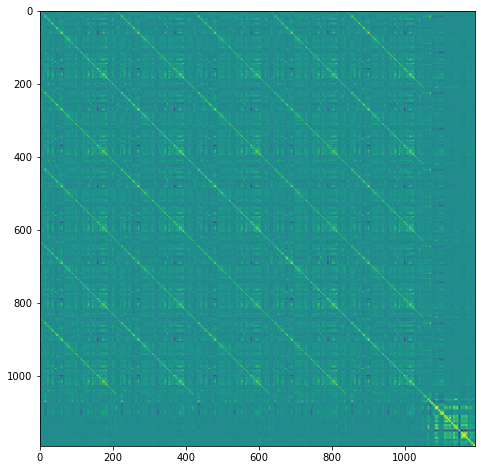

In [19]:
# The features are no longer explicit feature groups, but you can see some pretty obvious patterns if you
# visualize the feature correlation matrix. Feel free to construct your own groupings!
plt.figure(figsize = (8,8))
plt.imshow(df[df.era=='0001'][features].corr())

---
## High-level EDA

In [21]:
# check eras
df["era"].min(), df["era"].max()

('0001', '0574')

In [27]:
# era median point
eras.median()

304.0

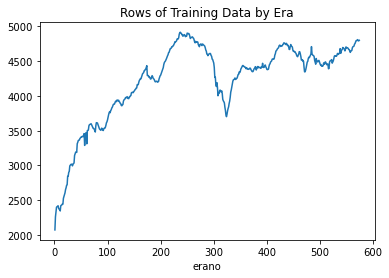

In [22]:
# check data per era
df.groupby(eras).size().plot(title="Rows of Training Data by Era");

In [23]:
# targets are discrete
df.groupby("target").size() / len(df)

target
0.00    0.050007
0.25    0.200001
0.50    0.499975
0.75    0.200014
1.00    0.050003
dtype: float64

---
## Feature Correaltions

In [24]:
# check feature correlations
feature_corrs = df.loc[df["era"]=="0001"][features].corr()
feature_corrs.stack()

feature_honoured_observational_balaamite     feature_honoured_observational_balaamite       1.000000
                                             feature_polaroid_vadose_quinze                 0.002170
                                             feature_untidy_withdrawn_bargeman              0.141514
                                             feature_genuine_kyphotic_trehala               0.171890
                                             feature_unenthralled_sportful_schoolhouse     -0.149952
                                                                                              ...   
feature_polyphyletic_unplumed_pandiculation  feature_marxian_plated_refrigeration           0.945034
                                             feature_amative_irresponsive_flattie           0.951543
                                             feature_intermissive_coronal_reinsertion       0.896336
                                             feature_dwarfish_isochronal_amateur           

In [25]:
# some are very correlated or uncorrelated
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_optic_mycelial_whimper                      feature_productile_auriform_fil            -0.950579
feature_careworn_motivational_requisite             feature_loftier_sightly_lyric              -0.940453
feature_dissident_templed_shippon                   feature_rose_buttoned_dandy                -0.939489
feature_applausive_forgettable_mishanter            feature_marled_coliform_proctorship        -0.936837
feature_sodding_choosy_eruption                     feature_utmost_excitable_emir              -0.934667
                                                                                                  ...   
feature_bimanual_godly_witloof                      feature_healthier_unconnected_clave         1.000000
feature_associate_unproper_gridder                  feature_asteriated_invigorated_penitence    1.000000
feature_agricultural_uranic_ankerite                feature_pseudo_bounden_hereafter            1.000000
feature_associate_unproper_gridder                  fea

In [38]:
# split df into first and second halves
df1 = df[eras<=eras.median()]
df2 = df[eras>eras.median()]

In [39]:
# get feature correlations in both halves
corr1 = df1[df1.era=='0001'][features].corr().unstack()
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]
corr2 = df2[df2.era=='0574'][features].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [40]:
# observe changes in features over time
tdf = pd.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
tdf.sort_values(by="corr_diff")

corr1  \
feature_cislunar_ritardando_gadwall        feature_uranian_gorier_melancholy           1.000000   
feature_baggier_supernormal_calcedony      feature_uranian_gorier_melancholy           1.000000   
feature_cislunar_ritardando_gadwall        feature_unscaling_pedantic_fingernail       1.000000   
feature_rutilant_obliterate_potassium      feature_torose_unspiritualised_kylie        1.000000   
                                           feature_uranian_gorier_melancholy           1.000000   
...                                                                                         ...   
feature_anucleate_knotted_nonage           feature_asteriated_invigorated_penitence   -0.097878   
feature_flamier_confusing_dithering        feature_nonagenarian_roundish_publication  -0.078833   
feature_comprisable_commensurable_cyrenaic feature_nonagenarian_roundish_publication  -0.070878   
feature_cragged_sacred_malabo              feature_disarrayed_rarefactive_trisulphide -0.137175   
feature_maglemosian_kittle_coachbuilding   feature_unreeling_homeothermic_macedonia   -0.088717   

                                                                                          corr2  \
feature_cislunar_ritardando_gadwall        feature_uranian_gorier_melancholy          -0.165348   
feature_baggier_supernormal_calcedony      feature_uranian_gorier_melancholy          -0.164931   
feature_cislunar_ritardando_gadwall        feature_unscaling_pedantic_fingernail      -0.162745   
feature_rutilant_obliterate_potassium      feature_torose_unspiritualised_kylie       -0.161912   
                                           feature_uranian_gorier_melancholy          -0.161704   
...                                                                                         ...   
feature_anucleate_knotted_nonage           feature_asteriated_invigorated_penitence    0.736776   
feature_flamier_confusing_dithering        feature_nonagenarian_roundish_publication   0.757289   
feature_comprisable_commensurable_cyrenaic feature_nonagenarian_roundish_publication   0.766556   
feature_cragged_sacred_malabo              feature_disarrayed_rarefactive_trisulphide  0.720117   
feature_maglemosian_kittle_coachbuilding   feature_unreeling_homeothermic_macedonia    0.783528   

                                                                                       corr_diff  
feature_cislunar_ritardando_gadwall        feature_uranian_gorier_melancholy           -1.165348  
feature_baggier_supernormal_calcedony      feature_uranian_gorier_melancholy           -1.164931  
feature_cislunar_ritardando_gadwall        feature_unscaling_pedantic_fingernail       -1.162745  
feature_rutilant_obliterate_potassium      feature_torose_unspiritualised_kylie        -1.161912  
                                           feature_uranian_gorier_melancholy           -1.161704  
...                                                                                          ...  
feature_anucleate_knotted_nonage           feature_asteriated_invigorated_penitence     0.834655  
feature_flamier_confusing_dithering        feature_nonagenarian_roundish_publication    0.836122  
feature_comprisable_commensurable_cyrenaic feature_nonagenarian_roundish_publication    0.837433  
feature_cragged_sacred_malabo              feature_disarrayed_rarefactive_trisulphide   0.857291  
feature_maglemosian_kittle_coachbuilding   feature_unreeling_homeothermic_macedonia     0.872245  

[708645 rows x 3 columns]

---
## Self-Predicitive Features

In [63]:
# pearson correlation score
feature_scores = {
    feature: score for feature, score 
    in zip(features, np.corrcoef(df[df.era=='0001'][[target]+features].T)[1:,0])
}

In [58]:
# some features are predictive on their own
pd.Series(feature_scores).sort_values()

feature_steric_coxcombic_relinquishment          -0.081221
feature_unsustaining_chewier_adnoun              -0.081221
feature_drizzling_refrigerative_imperfection     -0.072832
feature_censorial_leachier_rickshaw              -0.071307
feature_quodlibetic_enrapt_miscalculation        -0.069781
                                                    ...   
feature_unperched_forgetive_vasoconstrictor       0.056435
feature_cockiest_ditheistical_pennyworth          0.056817
feature_tuberculate_patelliform_paging            0.057198
feature_uninquiring_unspiritualized_gradualism    0.059867
feature_unsizable_ancestral_collocutor            0.061011
Length: 1191, dtype: float64

<AxesSubplot:>

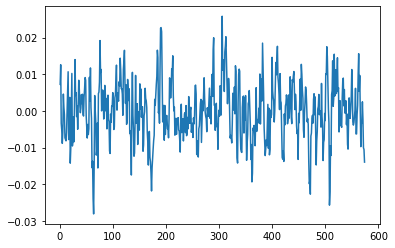

In [59]:
# however, single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf[target], tdf["feature_untidy_withdrawn_bargeman"])[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot()

<AxesSubplot:>

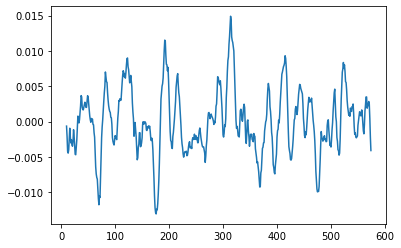

In [60]:
# with a rolling 10 era average you can see some trends
by_era_correlation.rolling(10).mean().plot()

---
## Feature Exposures to Targets

In [65]:
# check feature correlation of nomi_v4_20
feature_scores_nomi20 = {
    feature: score for feature, score 
    in zip(features, np.corrcoef(df[df.era=='0001'][['target_nomi_v4_20'] + features].T)[1:,0])
}

In [66]:
# check feature correlation of nomi_v4_60
feature_scores_nomi60 = {
    feature: score for feature, score 
    in zip(features, np.corrcoef(df[df.era=='0001'][['target_nomi_v4_60'] + features].fillna(0.5).T)[1:, 0])}

0.680901621349402


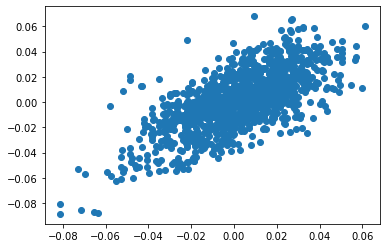

In [67]:
# correlation between two target's exposures to features
plt.scatter(feature_scores_nomi20.values(), feature_scores_nomi60.values())
print(np.corrcoef(list(feature_scores_nomi20.values()), list(feature_scores_nomi60.values()))[0,1])

0.33993486663275885


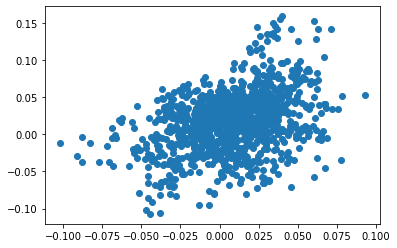

In [69]:
# now check jerome_v4_60 and ben_v4_20 targets
feature_scores_jerome = {
    feature: score for feature, score 
    in zip(features, np.corrcoef(df[df.era=='0001'][['target_jerome_v4_60'] + features].fillna(0.5).T)[1:, 0])
}

feature_scores_ben = {
    feature: score for feature, score 
    in zip(features, np.corrcoef(df[df.era=='0001'][['target_ben_v4_20'] + features].fillna(0.5).T)[1:, 0])
}

plt.scatter(feature_scores_jerome.values(), feature_scores_ben.values())
print(np.corrcoef(list(feature_scores_jerome.values()), list(feature_scores_ben.values()))[0,1])

---
# Feature Neutralization

In [74]:
# train a standard xgboost on half the train eras
lgb = lightgbm.LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.01, n_jobs=-1)
lgb.fit(df1[features], df1[target])
lgb_preds = lgb.predict(df2[features])

In [75]:
# check prediction correlation
corr_list = []
for feature in features:
    corr_list.append(np.corrcoef(df2[feature], lgb_preds)[0,1])
corr_series = pd.Series(corr_list, index=features)
corr_series.describe()

count    1191.000000
mean       -0.006798
std         0.087004
min        -0.446320
25%        -0.064243
50%         0.002217
75%         0.048784
max         0.235424
dtype: float64

In [77]:
# neutralize features
df2["preds"] = lgb_preds
df2["preds_neutralized"] = neutralize(
    df2, 
    columns=["preds"], 
    neutralizers=features, 
    proportion=0.5, 
    normalize=True,
    era_col='era'
)

In [78]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]])

/var/folders/__/dzz62y2949d5pjv8r63g_3n40000gn/T/ipykernel_30475/623447535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_neutralized"] = scaler.fit_transform(df2[["preds_neutralized"]])


In [79]:
# single feature exposures are minimized
corr_list2 = []
for feature in features:
    corr_list2.append(np.corrcoef(df2[feature], df2["preds_neutralized"])[0,1])
corr_series2 = pd.Series(corr_list2, index=features)
corr_series2.describe()

count    1191.000000
mean       -0.005279
std         0.065396
min        -0.333143
25%        -0.048212
50%         0.002013
75%         0.036379
max         0.178763
dtype: float64

In [80]:
# compare scores
unbalanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
balanced_scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized"], d[target])[0,1])

print("\nCompare Score:")
print(f"score for high feature exposure: {unbalanced_scores_per_era.mean()}")
print(f"score for balanced feature expo: {balanced_scores_per_era.mean()}")

print("\nCompare Stdev:")
print(f"std for high feature exposure: {unbalanced_scores_per_era.std(ddof=0)}")
print(f"std for balanced feature expo: {balanced_scores_per_era.std(ddof=0)}")

print("\nCompare Sharpe Ratio:")
print(f"sharpe for high feature exposure: {unbalanced_scores_per_era.mean()/unbalanced_scores_per_era.std(ddof=0)}")
print(f"sharpe for balanced feature expo: {balanced_scores_per_era.mean()/balanced_scores_per_era.std(ddof=0)}")


Compare Score:
score for high feature exposure: 0.055541468934456835
score for balanced feature expo: 0.050342243869086

Compare Stdev:
std for high feature exposure: 0.026172559005675087
std for balanced feature expo: 0.023254995366126418

Compare Sharpe Ratio:
sharpe for high feature exposure: 2.1221260375194335
sharpe for balanced feature expo: 2.1647926854638415


---
## Ensembling Models Trained on Different Targets

In [81]:
# two models each trained on different targets
lgb = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000, max_depth=5)
lgb.fit(df1[features], df1['target'])
lgb_jerome = lightgbm.LGBMRegressor(n_jobs=-1, learning_rate=0.01, n_estimators=1000, max_depth=5)
lgb_jerome.fit(df1[features], df1['target_jerome_v4_20'])

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

0.6366557798439411


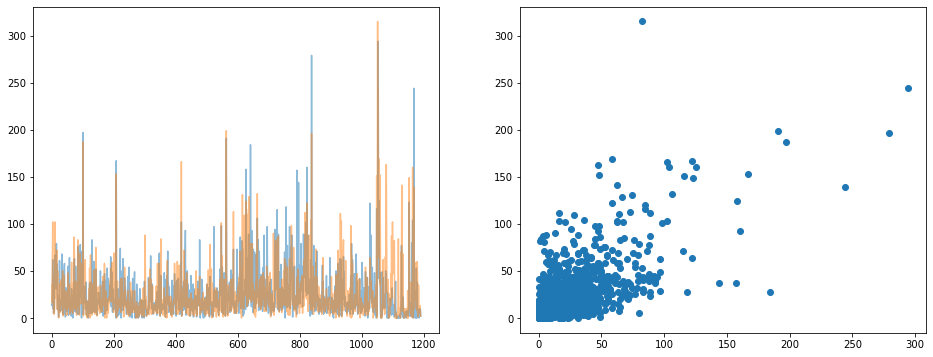

In [82]:
# The feature importances for each model are about 60% correlated
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(lgb.feature_importances_, alpha=.5)
plt.plot(lgb_jerome.feature_importances_, alpha=.5)
plt.subplot(1,2,2)
plt.scatter(lgb.feature_importances_, lgb_jerome.feature_importances_)

print(np.corrcoef([lgb.feature_importances_, lgb_jerome.feature_importances_])[0,1])

In [83]:
# predict
lgb_preds = lgb.predict(df2[features])
lgb_jerome_preds = lgb_jerome.predict(df2[features])

In [84]:
# The predictions are about 68% correlated
np.corrcoef([lgb_preds, lgb_jerome_preds])[0,1]

0.7011140413902851

In [86]:
# compute feature correlations with target on the first half data
all_feature_corrs = df1.groupby('era').apply(lambda d: d[features].corrwith(d[target]))

In [87]:
# compute the volatility of the feature correlations
feature_corr_volatility = all_feature_corrs.std()

In [88]:
# 50% neutralize to riskest features for each model as above
df2["preds"] = lgb_preds
df2["preds_jerome"] = lgb_jerome_preds

for preds in ["preds", "preds_jerome"]:
    feature_exposure_list = []
    for feature in features:
        feature_exposure_list.append(np.corrcoef(df2[feature], df2[preds])[0,1])
    feature_exposure_list = pd.Series(feature_exposure_list, index=features)
    riskiest_features = (feature_exposure_list.abs() * feature_corr_volatility).sort_values()[-100:].index.tolist()  
    df2[f"{preds}_neutralized_riskiest_100"] = neutralize(
        df2, 
        columns=[f"{preds}"], 
        neutralizers=riskiest_features, 
        proportion=0.5,
        normalize=True, 
        era_col='era'
    )

/var/folders/__/dzz62y2949d5pjv8r63g_3n40000gn/T/ipykernel_30475/2749678382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds"] = lgb_preds
/var/folders/__/dzz62y2949d5pjv8r63g_3n40000gn/T/ipykernel_30475/2749678382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_jerome"] = lgb_jerome_preds
/var/folders/__/dzz62y2949d5pjv8r63g_3n40000gn/T/ipykernel_30475/2749678382.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [89]:
# create ensemble
df2["preds_ens"] = (df2["preds"] + df2["preds_jerome"])/2

/var/folders/__/dzz62y2949d5pjv8r63g_3n40000gn/T/ipykernel_30475/271823728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["preds_ens"] = (df2["preds"] + df2["preds_jerome"])/2


In [90]:
# compare scores
scores = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d[target])[0,1])
scores_jerome = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome"], d[target])[0,1])

scores_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_neutralized_riskiest_100"], d[target])[0,1])
scores_jerome_derisked = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_jerome_neutralized_riskiest_100"], d[target])[0,1])

scores_ens = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds_ens"], d[target])[0,1])

print("\nCompare Score:")
print(f"target: {scores.mean()}")
print(f"target_jerome: {scores_jerome.mean()}")

print("\nCompare Sharpe:")
print(f"target: {scores.mean()/scores.std(ddof=0)}")
print(f"target_jerome: {scores_jerome.mean()/scores_jerome.std(ddof=0)}")

print("\nCompare Score Post-Neutralization:")
print(f"target: {scores_derisked.mean()}")
print(f"target_jerome: {scores_jerome_derisked.mean()}")

print("\nCompare Sharpe Post-Neutralization:")
print(f"target: {scores_derisked.mean()/scores_derisked.std(ddof=0)}")
print(f"target_jerome: {scores_jerome_derisked.mean()/scores_jerome_derisked.std(ddof=0)}")

print("\nCompare Ensemble Score & Sharpe:")
print(f"score ensemble: {scores_ens.mean()}")
print(f"sharpe ensemble: {scores_ens.mean()/scores_ens.std(ddof=0)}")


Compare Score:
target: 0.055541468934456835
target_jerome: 0.04789666580025999

Compare Sharpe:
target: 2.1221260375194335
target_jerome: 1.696866673070567

Compare Score Post-Neutralization:
target: 0.05203060464759513
target_jerome: 0.04847926536601591

Compare Sharpe Post-Neutralization:
target: 2.2190715602077598
target_jerome: 1.936022681189601

Compare Ensemble Score & Sharpe:
score ensemble: 0.055683561880376216
sharpe ensemble: 1.970636270189784


In [91]:
# calculate correlation of neutralized predictions
df2[[f"preds_neutralized_riskiest_100", f"preds_jerome_neutralized_riskiest_100"]].corr()

,preds_neutralized_riskiest_100,preds_jerome_neutralized_riskiest_100
preds_neutralized_riskiest_100,1.000000,0.669222
preds_jerome_neutralized_riskiest_100,0.669222,1.000000
